## Setup

In [1]:
# Import required modules.
import os
import glob
import cv2
import numpy as np
import tensorflow.compat.v1 as tf1
import tensorflow as tf2
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from pydnet.data import KITTI
from pydnet.models import Pydnet
from IPython.display import Image, display


# Path to PyDnet pretrained checkpoint.
CHECK_PATH = Path("../")\
    / "data"\
    / "checkpoint"\
    / "pydnet"\
    / "pydnet"

# Path to input file directory.
ORIG_PATH = Path("../")\
    / "data"\
    / "pexels"

# Path to output.
DEST_PATH = Path("../")\
    / "reports"\
    / "figures"

# Maximum depth value.
MAX_DEPTH = 80.0


# Disable Tensorflow warning messages.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 

# Run Tensorflow in earger mode.
if tf1.executing_eagerly():
   tf1.disable_eager_execution()

## Load PyDnet

In [2]:
# Load test images.
images = list(ORIG_PATH.glob("*.png"))
placeholder = tf1.placeholder(tf1.float32, shape=(320, 640, 3))
batch = tf1.expand_dims(placeholder, 0)

# Build PydNet.
network = Pydnet({
    "h": 320,
    "w": 640,
    "is_training": False
})

## Start Tensorflow session

In [3]:
# Setup test images feeding placeholder.
pred = network.forward(batch)
pred = tf1.nn.relu(pred)

# Setup Tensorflow session and restore checkpoint.
save = tf1.train.Saver()
sess = tf1.Session()
sess.run(tf1.global_variables_initializer())
save.restore(sess, str(CHECK_PATH))

INFO:tensorflow:Restoring parameters from ../data/checkpoint/pydnet/pydnet


## Run inference on test images

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.03it/s]


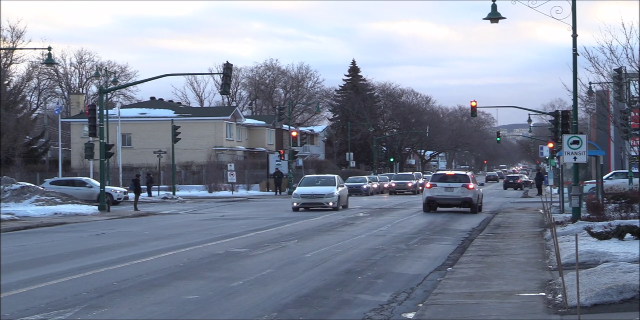

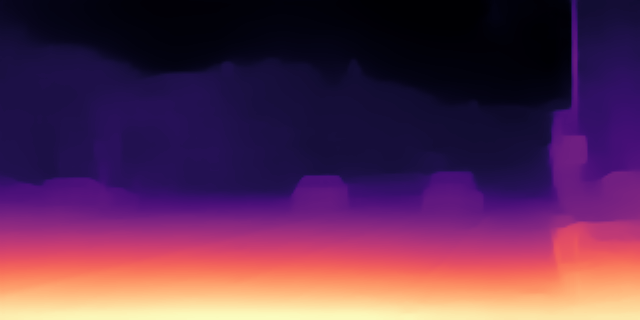

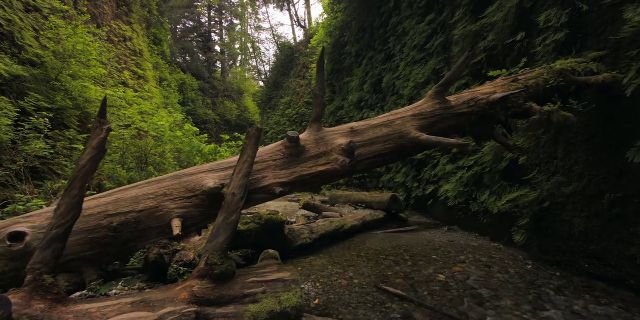

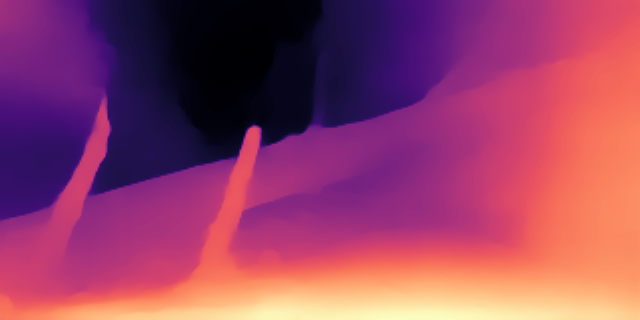

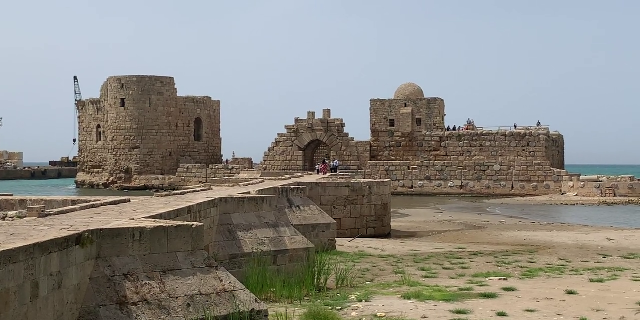

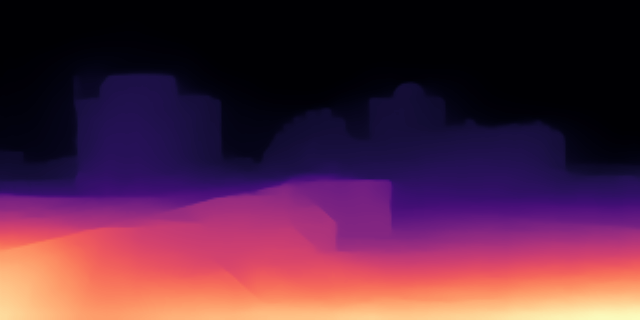

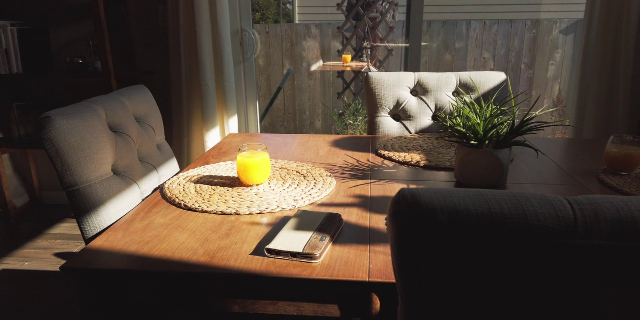

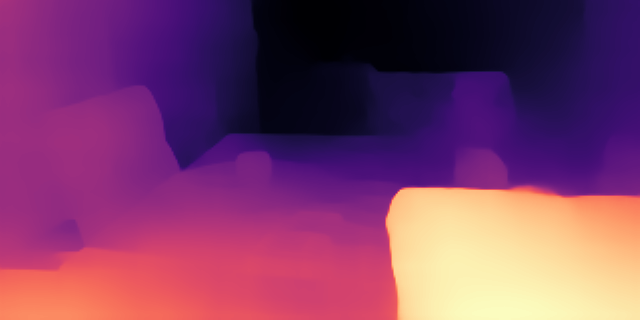

In [4]:
# Makedir output directory.
DEST_PATH.mkdir(
    parents=True,
    exist_ok=True)

# Run inference on test images.
for i in tqdm(range(len(images))):
    image = cv2.imread(str(images[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    image = cv2.resize(image, (640, 320))
    image = image / 255.0
    dep = sess.run(
        pred,
        feed_dict={placeholder: image})
    dep = np.squeeze(dep)
    min_dep = dep.min()
    max_dep = dep.max()
    dep = (dep - min_dep) / (max_dep - min_dep)
    dep *= 255.0
    dep = cv2.resize(dep, (w, h))
    plt.imsave(
        str(DEST_PATH / f"{images[i].stem}.png"),
        dep,
        cmap="magma")

# Display resulting image.
for i in range(len(images)):
    display(Image(filename=str(images[i])))
    display(Image(filename=str(DEST_PATH / f"{images[i].stem}.png")))